In [1]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
from pyha import Hardware, simulate, sims_close, Complex, Sfix

from pyha.common.float import Float, ComplexFloat

In [109]:
fft_size = 1024 * 8

In [110]:
hann_fix9 = np.array([ComplexFloat(x) for x in  np.hanning(fft_size)])
hann = np.hanning(fft_size)

In [111]:
comb = 4
if comb == 1:
    sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100)
    sig = np.array([ComplexFloat(x) for x in  sig])
    sig = sig * hann_fix9

    for i in range(100, 3000, 50):

        sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i)
        sig2 = np.array([ComplexFloat(x) for x in  sig2])
        sig2 = sig2 * hann_fix9
        sig = sig + sig2
elif comb == 2:
    sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100)
    sig = np.array([ComplexFloat(x) for x in  sig])
    sig = sig * hann_fix9

    for i in range(100, 300, 50//10):

        sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i * -1)
        sig2 = np.array([ComplexFloat(x) for x in  sig2])
        sig2 = sig2 * hann_fix9
        sig = sig + sig2
        
        
elif comb == 3:
    sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100)
    for i in range(100, 300, 1):
        sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i * -1)
        sig = sig + sig2

    sig_fix = sig
#     sig_fix = np.array([Complex(x, 0, -11, overflow_style='saturate').val for x in  sig_fix]) # simulate ADC
    sig_fix = np.array([ComplexFloat(x) for x in  sig_fix])
    sig_fix *= hann_fix9
    
    sig *= hann
    
else:
    sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100)
    sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 110)
    sig = sig + sig2
    sig_fix = np.array([ComplexFloat(x) for x in  sig])
    sig_fix *= hann_fix9
    sig *= hann

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


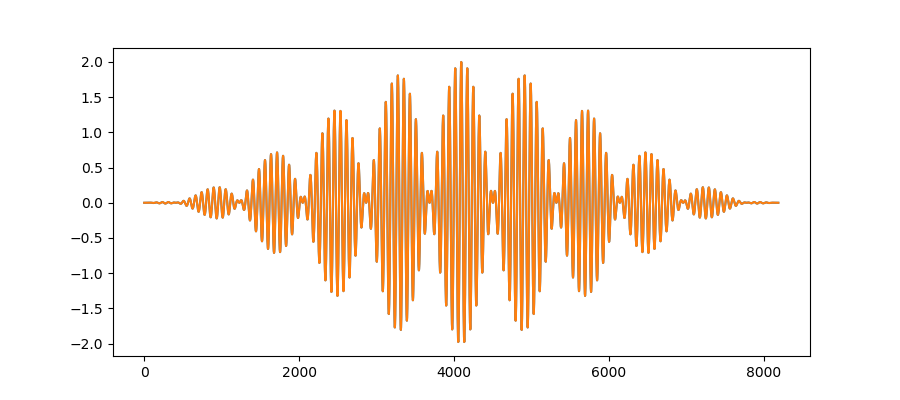

In [112]:
plt.plot([complex(x) for x in sig_fix])
plt.plot(sig)
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


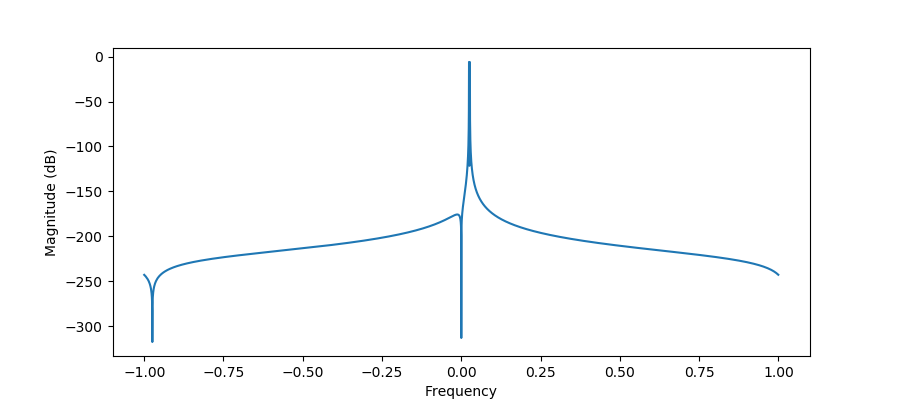

In [113]:
plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.show()

In [122]:
dut = R2SDF(fft_size)
sims = simulate(dut, sig_fix, simulations=['PYHA'], output_callback=unpackage, input_callback=package)

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 16384/16384 [00:44<00:00, 364.62it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [123]:
sims['PYHA'][0] = [complex(x) for x in sims['PYHA'][0]]

In [124]:
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

pyh = np.array(sims['PYHA'][0])
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


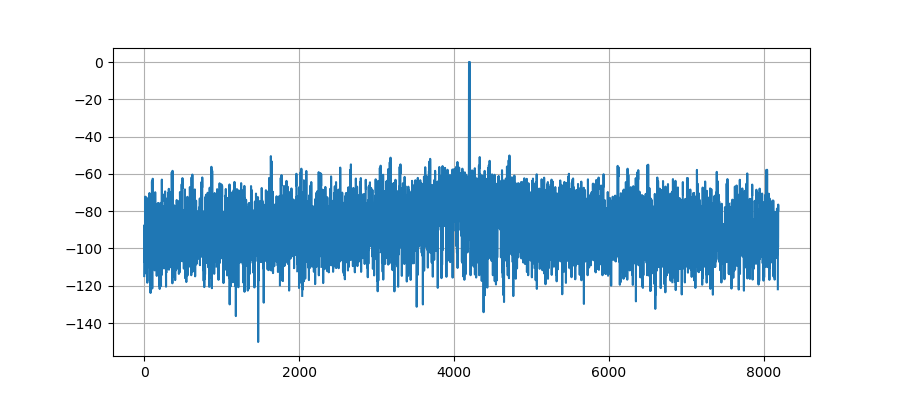

In [125]:
a = 20 * np.log10(pyh)
plt.plot(a)
# plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


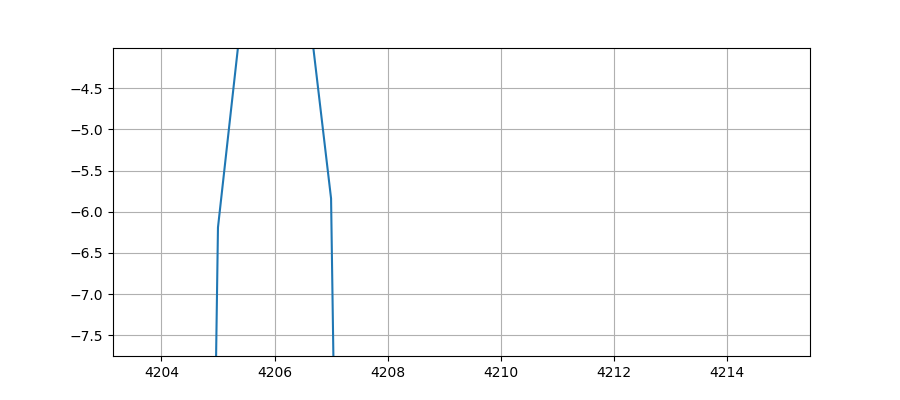

In [117]:
a = 20 * np.log10(pyh)
plt.plot(a)
# plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


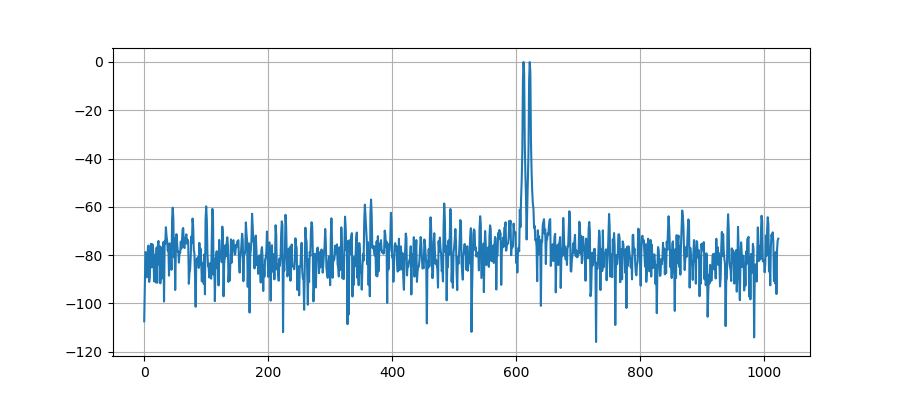

In [55]:
a = 20 * np.log10(pyh)
plt.plot(a)
# plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

# MULTI_SINE

In [ ]:
sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100)
sig = sig * np.hamming(fft_size)

for i in range(100, 3000, 50):

    sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i)
    # sig2 = np.array([ComplexFloat(x) for x in  sig2])
    sig2 = sig2 * np.hamming(fft_size)
    sig = sig + sig2

In [ ]:
plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.show()

In [ ]:
M = 1024 * 8
hann = np.hanning(M)
# hann = hann / hann.max()
hann_fix18 = np.array([Sfix(x, 0, -17, round_style='round', overflow_style='saturate').val for x in hann])
hann_fix9 = np.array([Sfix(x, 0, -8, round_style='round', overflow_style='saturate').val for x in hann])

In [ ]:
plt.plot(hann)
plt.plot(hann_fix18)
plt.plot(hann_fix9)
show_plot()

In [ ]:
fft_size = 1024